## Градиентный спуск

In [2]:
from typing import List, Iterable

import numpy as np
import matplotlib.pyplot as plt
import abc

import numpy as np
import pandas as pd
from numpy import linalg
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import time

Создадим абстрактный класс

In [8]:
class BaseLoss(abc.ABC):
    @abc.abstractmethod
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray):
        raise NotImplementedError
        #ф-я для вычисления лосса

    @abc.abstractmethod
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray):
        raise NotImplementedError
        #ф-я для вычисления градиента

Теперь реализуем MSELoss класс

In [11]:
class MSELoss(BaseLoss):
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray):
        Q = ((linalg.norm(np.dot(X, w) - y)) ** 2) / len(y)
        return Q
        
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray):
        L = np.dot(X,w) - y
        Xt = np.transpose(X)
        Grad = 2 * np.dot(Xt, L) / len(y)
        return Grad

Проверим наш класс MSELoss и сделаем подсчеты

In [13]:
loss = MSELoss()

X = np.arange(200).reshape(20, 10)
y = np.arange(20)
w = np.arange(10)

print(loss.calc_loss(X,y,w))
print(loss.calc_grad(X,y,w))

27410283.5
[1163180. 1172281. 1181382. 1190483. 1199584. 1208685. 1217786. 1226887.
 1235988. 1245089.]


Реализуем ф-ю градиентного спуска (GD)

Отлично, у нас есть градиент функционала и теперь мы можем его испоользовать для градиентого спуска

In [15]:
def gradient_descent(w_init: np.ndarray, X: np.ndarray, y: np.ndarray,
                    loss: BaseLoss, lr: float, n_iterations: int = 100000):
    '''
    w_init - изначальное значение вектора весов
    loss - объект класса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X,y)
    lr - параметр величины шага, на который нужно домножать градиент
    n_iterations - кол-во итераций
    return - список из n_itreations объектов размера n_features - история весов на каждом шаге
    '''
    W = []
    for i in range(n_iterations):
        w_init_new = w_init - lr * loss.calc_grad(X,y, w_init)
        W.append(w_init_new)
        w_init = w_init_new
    return W

Всё готов, теперь сделаем синтетический датасет и функцию, которая будет визуализировать наш градиентный спуск по истории

In [73]:
np.random.seed(1337)

n_features = 2 #стоит наверное это делать через кол-во признаков 
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features, ))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X = X * (np.arange(n_features) * 2 + 1)[np.newaxis, :]
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2,2, (n_features))
w_init

array([0.62074297, 1.79288146])

In [29]:
loss = MSELoss()

In [71]:
w_list = gradient_descent(w_init, X, y, loss, 0.01, 100) #получили историю наших весов
w_list

[array([ 0.44735749, -1.8304003 ]),
 array([0.26091556, 0.31793598]),
 array([ 0.12674895, -0.95904084]),
 array([-0.00077067, -0.20269022]),
 array([-0.10035868, -0.65294595]),
 array([-0.18955348, -0.38683404]),
 array([-0.26209584, -0.54573687]),
 array([-0.32521258, -0.45223178]),
 array([-0.3775857 , -0.50841489]),
 array([-0.42251159, -0.47564759]),
 array([-0.46016098, -0.49558625]),
 array([-0.49223243, -0.4841667 ]),
 array([-0.51924072, -0.4912955 ]),
 array([-0.54216889, -0.48736123]),
 array([-0.56152377, -0.48994757]),
 array([-0.57792705, -0.48862505]),
 array([-0.59179029, -0.48958987]),
 array([-0.60352966, -0.48916939]),
 array([-0.61345697, -0.48954772]),
 array([-0.62185998, -0.48943211]),
 array([-0.62896794, -0.48959291]),
 array([-0.6349833 , -0.48957547]),
 array([-0.64007231, -0.48965182]),
 array([-0.64437863, -0.48966234]),
 array([-0.64802204, -0.48970334]),
 array([-0.65110494, -0.48971898]),
 array([-0.65371336, -0.48974352]),
 array([-0.65592044, -0.489757

Теперь посмотрим на функционал ошибки при разных весах

In [43]:
print(loss.calc_loss(X,y, w_list[0]))
print(loss.calc_loss(X,y, w_list[-1]))
print(mean_squared_error(y, np.dot(X,w_list[-1])))

155.26258214351958
0.8670644395649494
0.8670644395649493


Создадим функцию plot_gd , которая будет делать построение градиентного спуска

In [123]:
def plot_gd(w_list: Iterable, X: np.ndarray, y: np.ndarray, loss:BaseLoss):
    w_list = np.array(w_list)
    meshgrid_space = np.linspace(-2,2,100)
    A,B = np.meshgrid(meshgrid_space, meshgrid_space) #создаем сетку

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i,j], B[i,j]])
            levels[i,j] = loss.calc_loss(X,y,w_tmp)
            
    plt.figure(figsize=(15,6))
    plt.title('GD TRAJECTORY')
    plt.xlabel('w1')
    plt.ylabel('w2')
    plt.xlim(w_list[:, 0].min() - 0.1, #масштаб для w1
             w_list[:, 0].max() + 0.1)
    plt.ylim(w_list[:, 1].min() - 0.1, #масштаб для w2
             w_list[:, 1].max() + 0.1)
    # plt.gca().set_aspect('equal')

    CS = plt.contour(A,B,levels, levels=np.logspace(0,1,num=20), cmap=plt.cm.rainbow_r)   #контуры
    CB = plt.colorbar(CS, shrink=0.8, extend='both')                                      #бар справа

    plt.scatter(w_list[:,0], w_list[:,1])
    plt.plot(w_list[:,0], w_list[:,1])
    plt.show()


длина шага: 0.0001


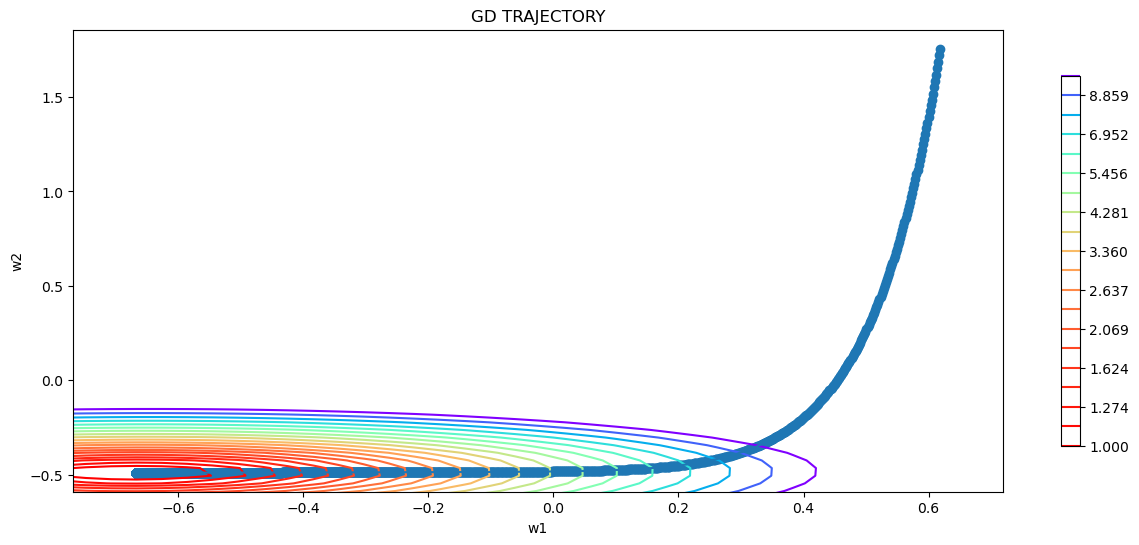

длина шага: 0.001


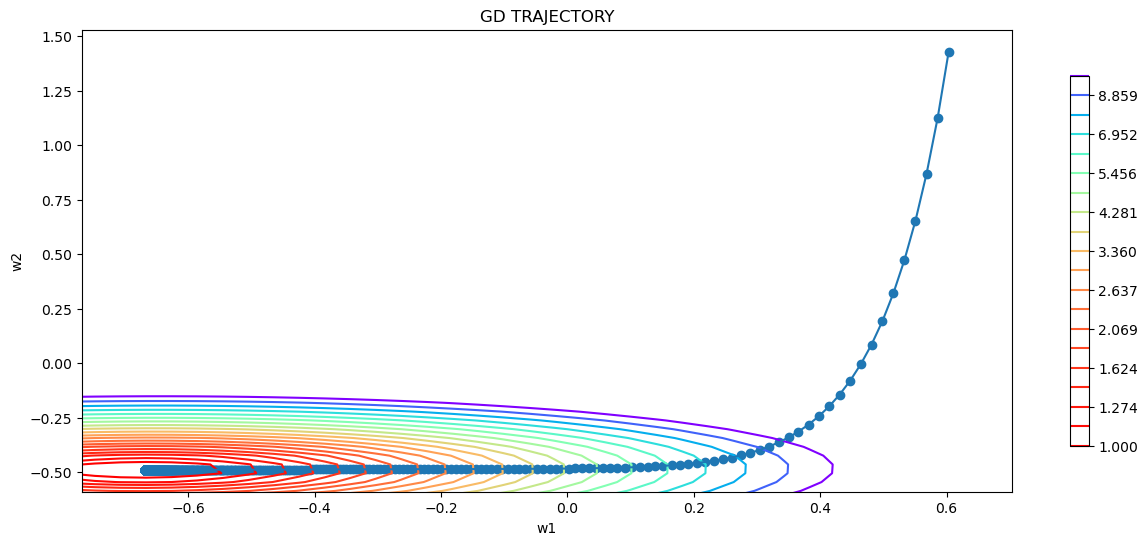

длина шага: 0.01


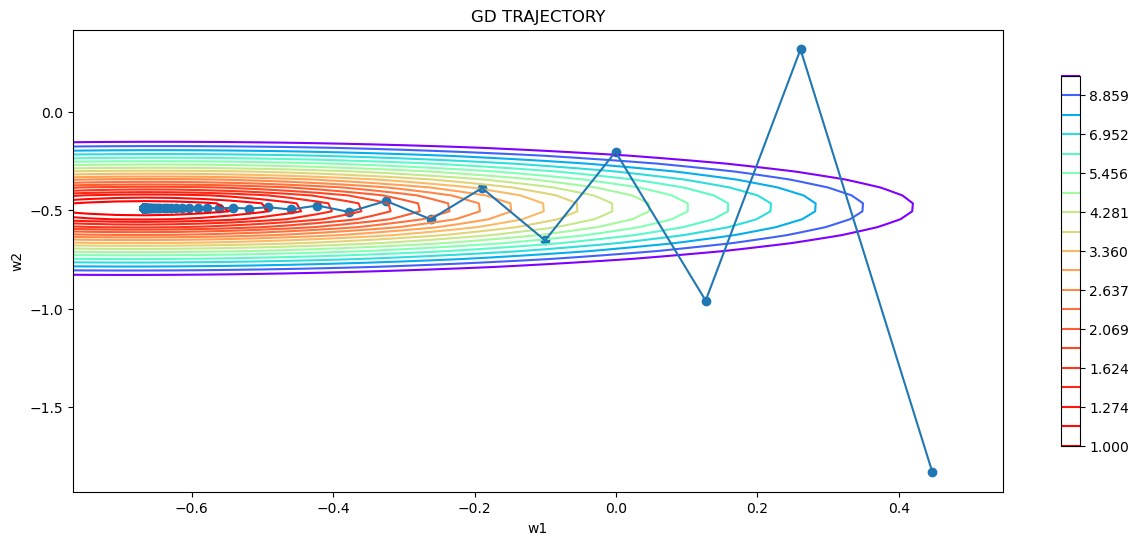

длина шага: 0.012


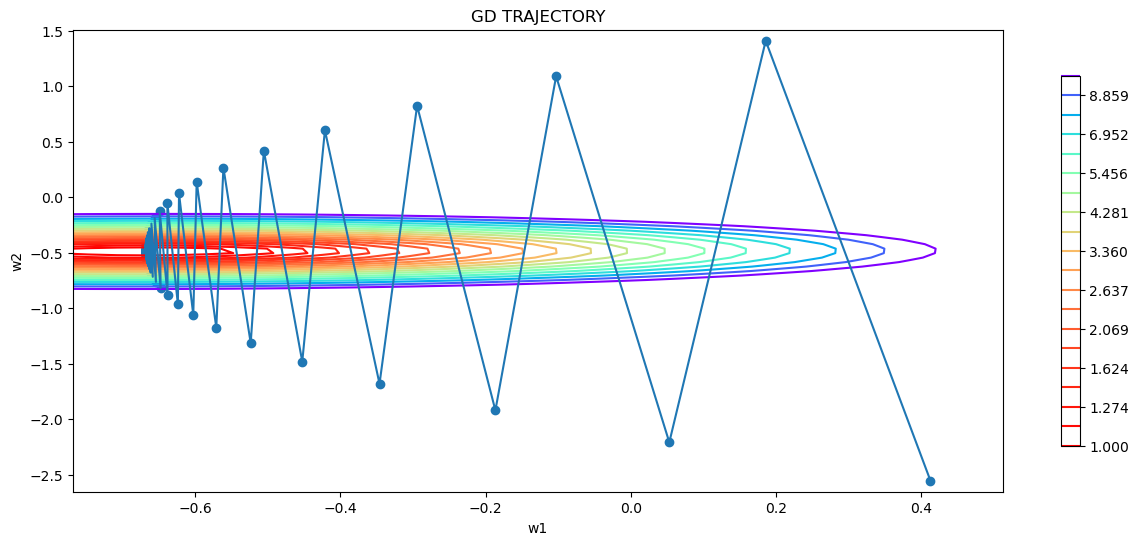

In [125]:
lr = [0.0001, 0.001, 0.01, 0.012]

for el in lr:
    w_list = gradient_descent(w_init, X,y, loss, el)
    print('длина шага:', el)
    plot_gd(w_list, X, y, loss)

Теперь реализуем Стохастический Градиентный Спуск (SGD)

In [218]:
def stochastic_gradient_descent(w_init: np.ndarray, X: np.ndarray, y: np.ndarray,
                        loss: BaseLoss, lr: float, batch_size: int, n_iterations: int = 1000):

    W = []
    for i in range(n_iterations):
        batch_indices = np.random.choice(X.shape[0], size=batch_size)
        X_batch = X[batch_indices]
        y_batch = y[batch_indices]
        w_init_new = w_init - lr * loss.calc_grad(X_batch, y_batch, w_init)
        W.append(w_init_new)
        w_init = w_init_new
    return W

batch_size =  1 , lr =  0.0001
 --- 0.045379638671875 seconds ---


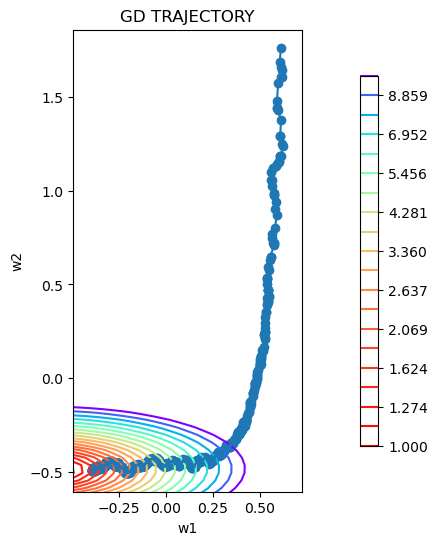

batch_size =  1 , lr =  0.001
 --- 0.03885674476623535 seconds ---


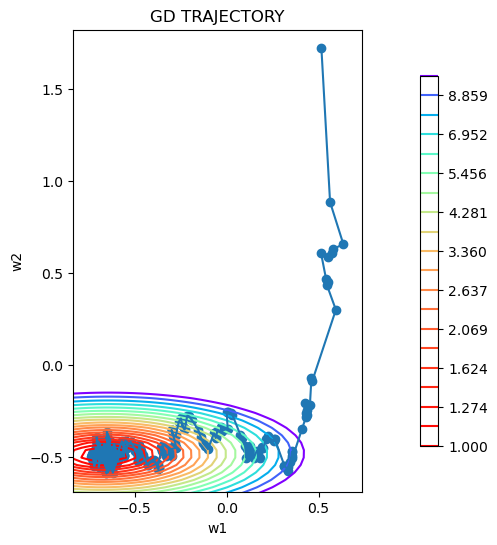

batch_size =  1 , lr =  0.01
 --- 0.03888225555419922 seconds ---


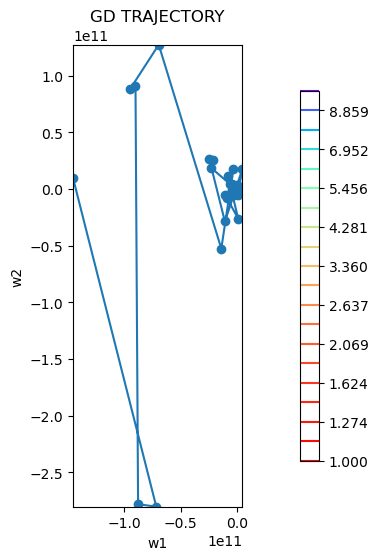

batch_size =  1 , lr =  0.012
 --- 0.0807037353515625 seconds ---


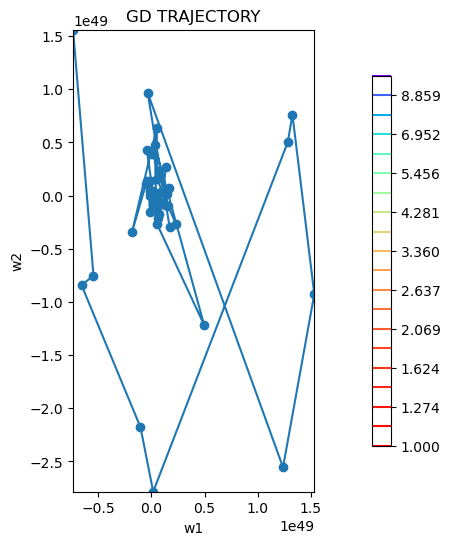

batch_size =  10 , lr =  0.0001
 --- 0.04485940933227539 seconds ---


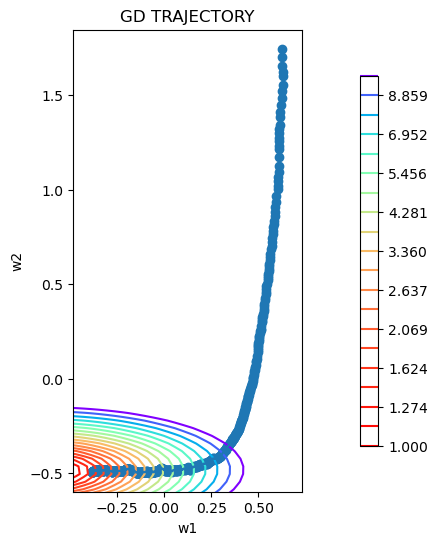

batch_size =  10 , lr =  0.001
 --- 0.04479169845581055 seconds ---


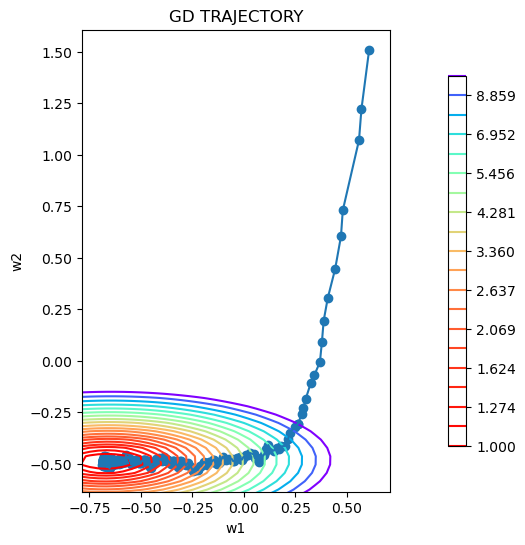

batch_size =  10 , lr =  0.01
 --- 0.05186271667480469 seconds ---


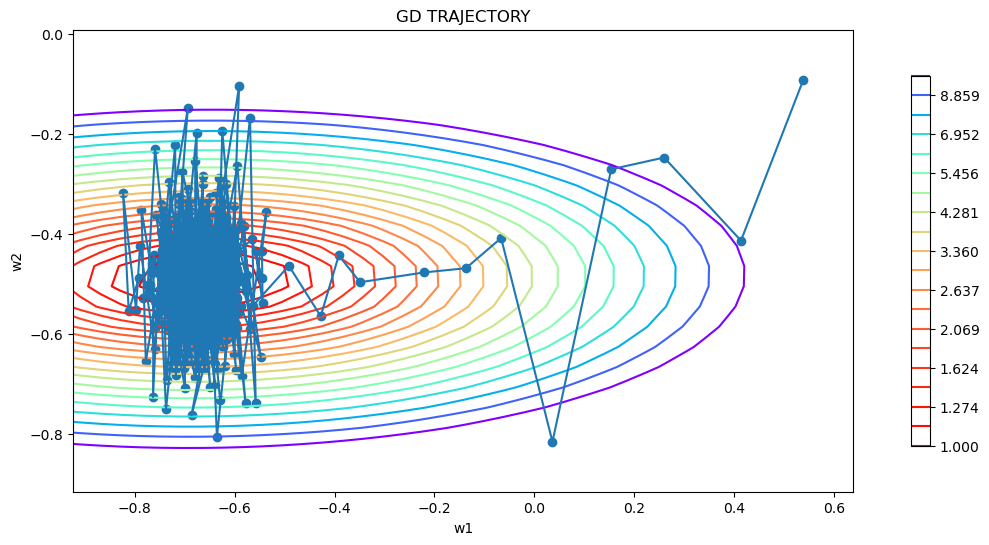

batch_size =  10 , lr =  0.012
 --- 0.0348970890045166 seconds ---


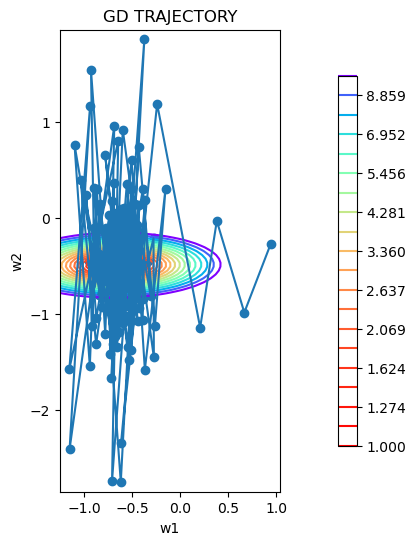

batch_size =  100 , lr =  0.0001
 --- 0.043863534927368164 seconds ---


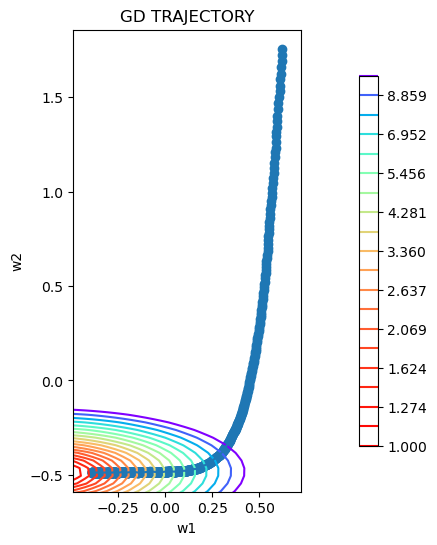

batch_size =  100 , lr =  0.001
 --- 0.04087233543395996 seconds ---


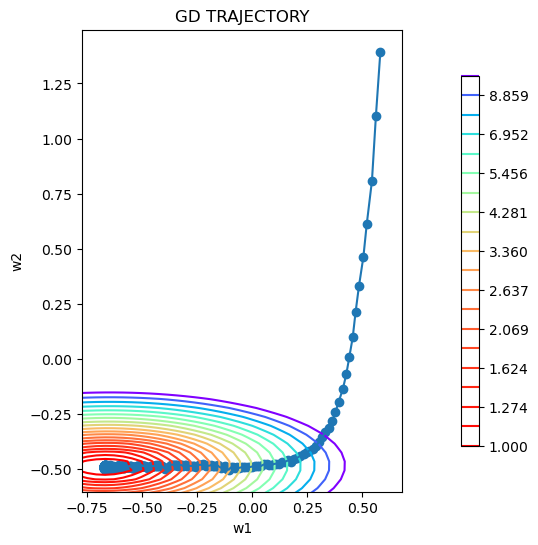

batch_size =  100 , lr =  0.01
 --- 0.04585742950439453 seconds ---


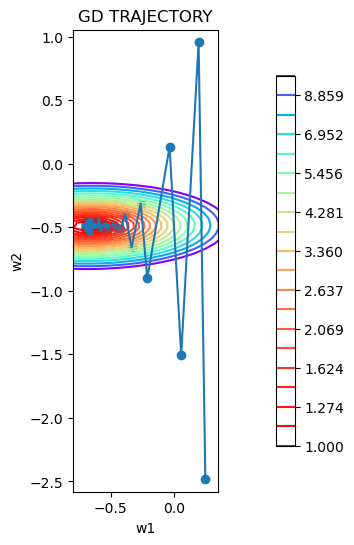

batch_size =  100 , lr =  0.012
 --- 0.036850690841674805 seconds ---


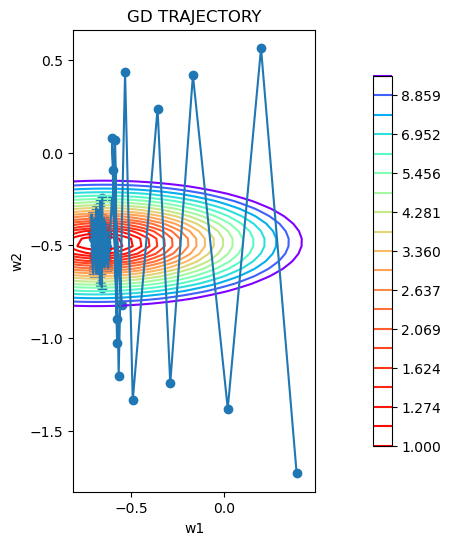

batch_size =  200 , lr =  0.0001
 --- 0.046845197677612305 seconds ---


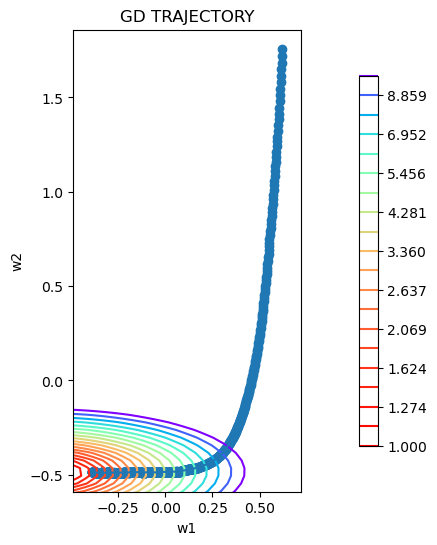

batch_size =  200 , lr =  0.001
 --- 0.04387831687927246 seconds ---


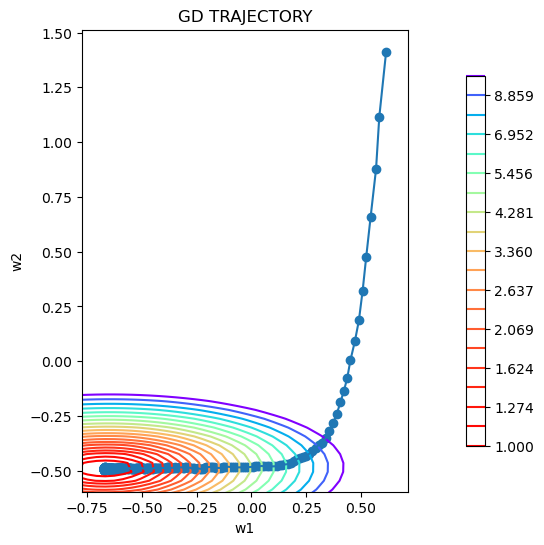

batch_size =  200 , lr =  0.01
 --- 0.043853759765625 seconds ---


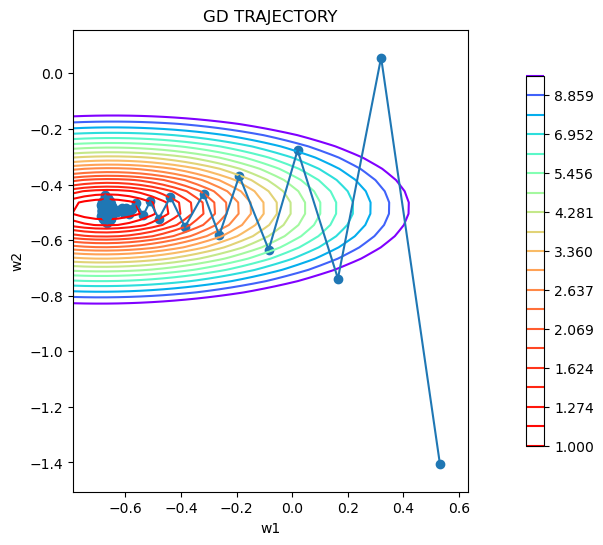

batch_size =  200 , lr =  0.012
 --- 0.04788923263549805 seconds ---


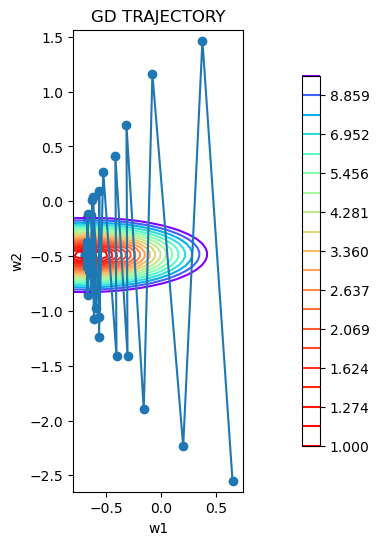

In [220]:
lr = [0.0001, 0.001, 0.01, 0.012]
batch_size = [1, 10, 100, 200]

for j in range(len(batch_size)):
    for i in range(len(lr)):
        start_time = time.time()
        w_list = stochastic_gradient_descent(w_init, X, y, loss, lr[i], batch_size[j])
        print('batch_size = ', batch_size[j], ',', 'lr = ', lr[i])
        print(" --- %s seconds ---" % (time.time() - start_time))
        plot_gd(w_list, X, y, loss)

Также в градиентом спуске есть затухающий коэффициент
$$
    \eta_t
    =
    \lambda
    \left(
        \frac{s_0}{s_0 + t}
    \right)^p
$$


Реализуем Стохастиеческий Градиентный Спуск выше с затухающим коэффициентом. Возьмем s_0 = 1.

In [224]:
def stochastic_gradient_descent(w_init: np.ndarray, X: np.ndarray, y: np.ndarray,
                        loss: BaseLoss, lr: float, batch_size: int, p: float, n_iterations: int = 1000) -> List[np.ndarray]:
    s0 = 1
    W = []

    for i in range(n_iterations):
        batch_indices = np.random.choice(X.shape[0], size=batch_size)
        X_batch = X[batch_indices]
        y_batch = y[batch_indices]
        w_init_new = w_init - lr*((s0/(s0 + i))**p)*loss.calc_grad(X_batch, y_batch, w_init)
        W.append(w_init_new)
        w_init = w_init_new

    return W

p =  0.1


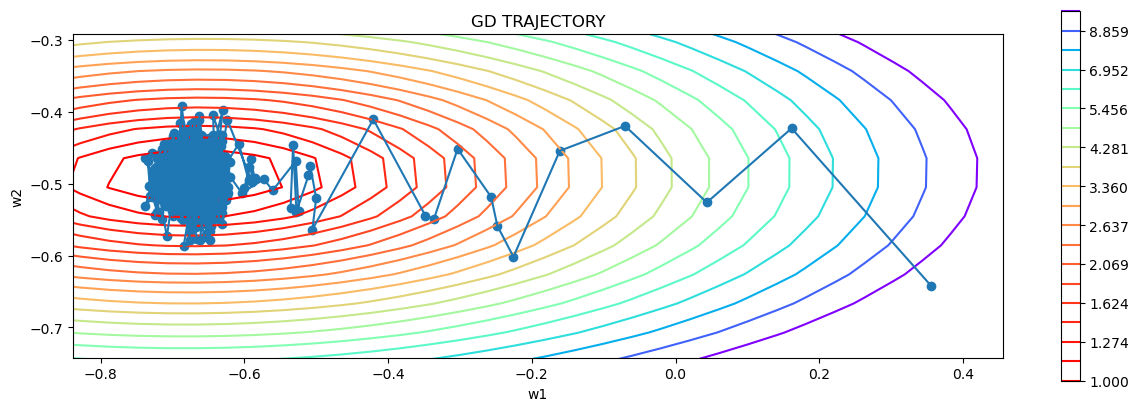

p =  0.3


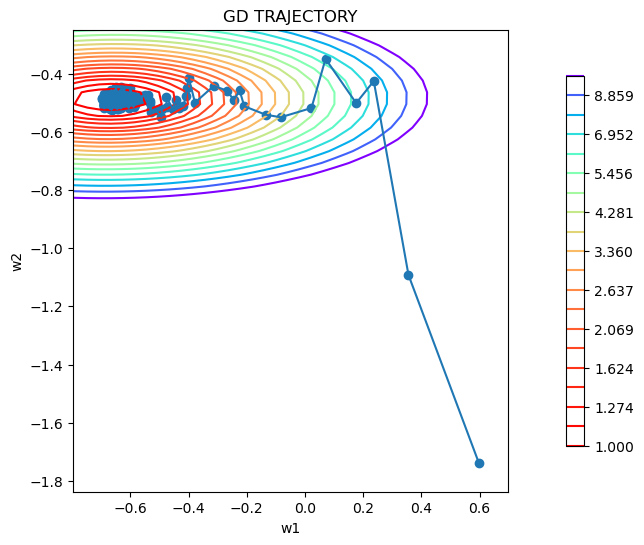

p =  0.6


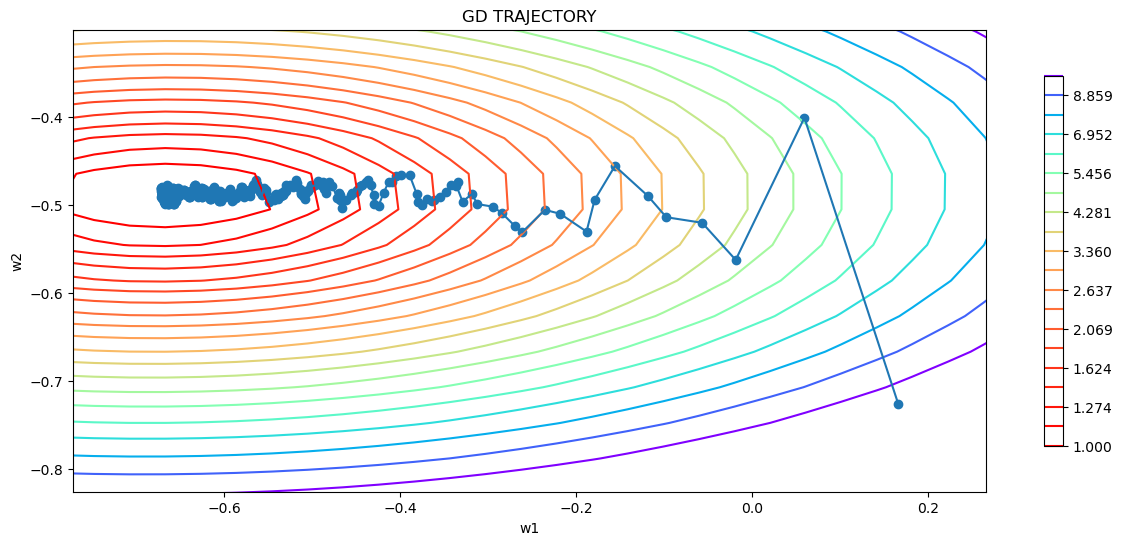

p =  0.9


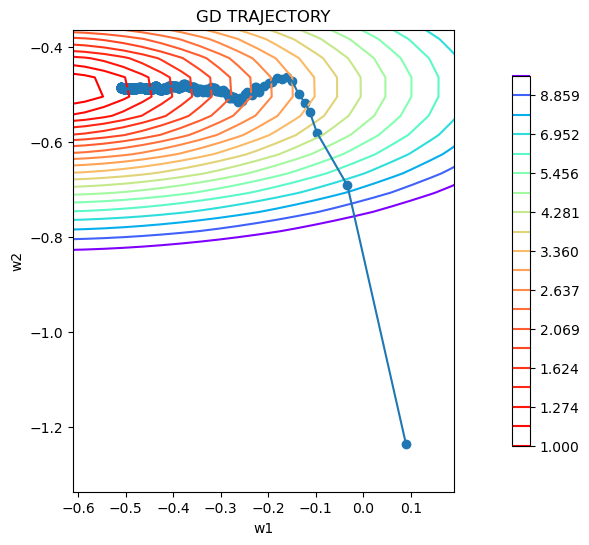

In [226]:
p = [0.1, 0.3, 0.6, 0.9]

for i in range(len(p)):
    w_list = stochastic_gradient_descent(w_init, X, y, loss, lr=0.01, batch_size=10, p = p[i])
    print('p = ', p[i])
    plot_gd(w_list, X, y, loss)

In [249]:
gd = []
k_gd = []
loss = MSELoss()

w_list = gradient_descent(w_init, X,y, loss, 0.01, 100)
for i in range(len(w_list)):
    losses_gd = loss.calc_loss(X,y,w_list[i])
    gd.append(losses_gd)
    k_gd.append(i)
    
k_sgd = []
sgd = []
loss = MSELoss()

w_list = stochastic_gradient_descent(w_init, X, y, loss, lr=0.01, batch_size=10, p = 0.1, n_iterations=100)
for i in range(len(w_list)):
    losses_sgd = loss.calc_loss(X,y, w_list[i])
    sgd.append(losses_sgd)
    k_sgd.append(i)

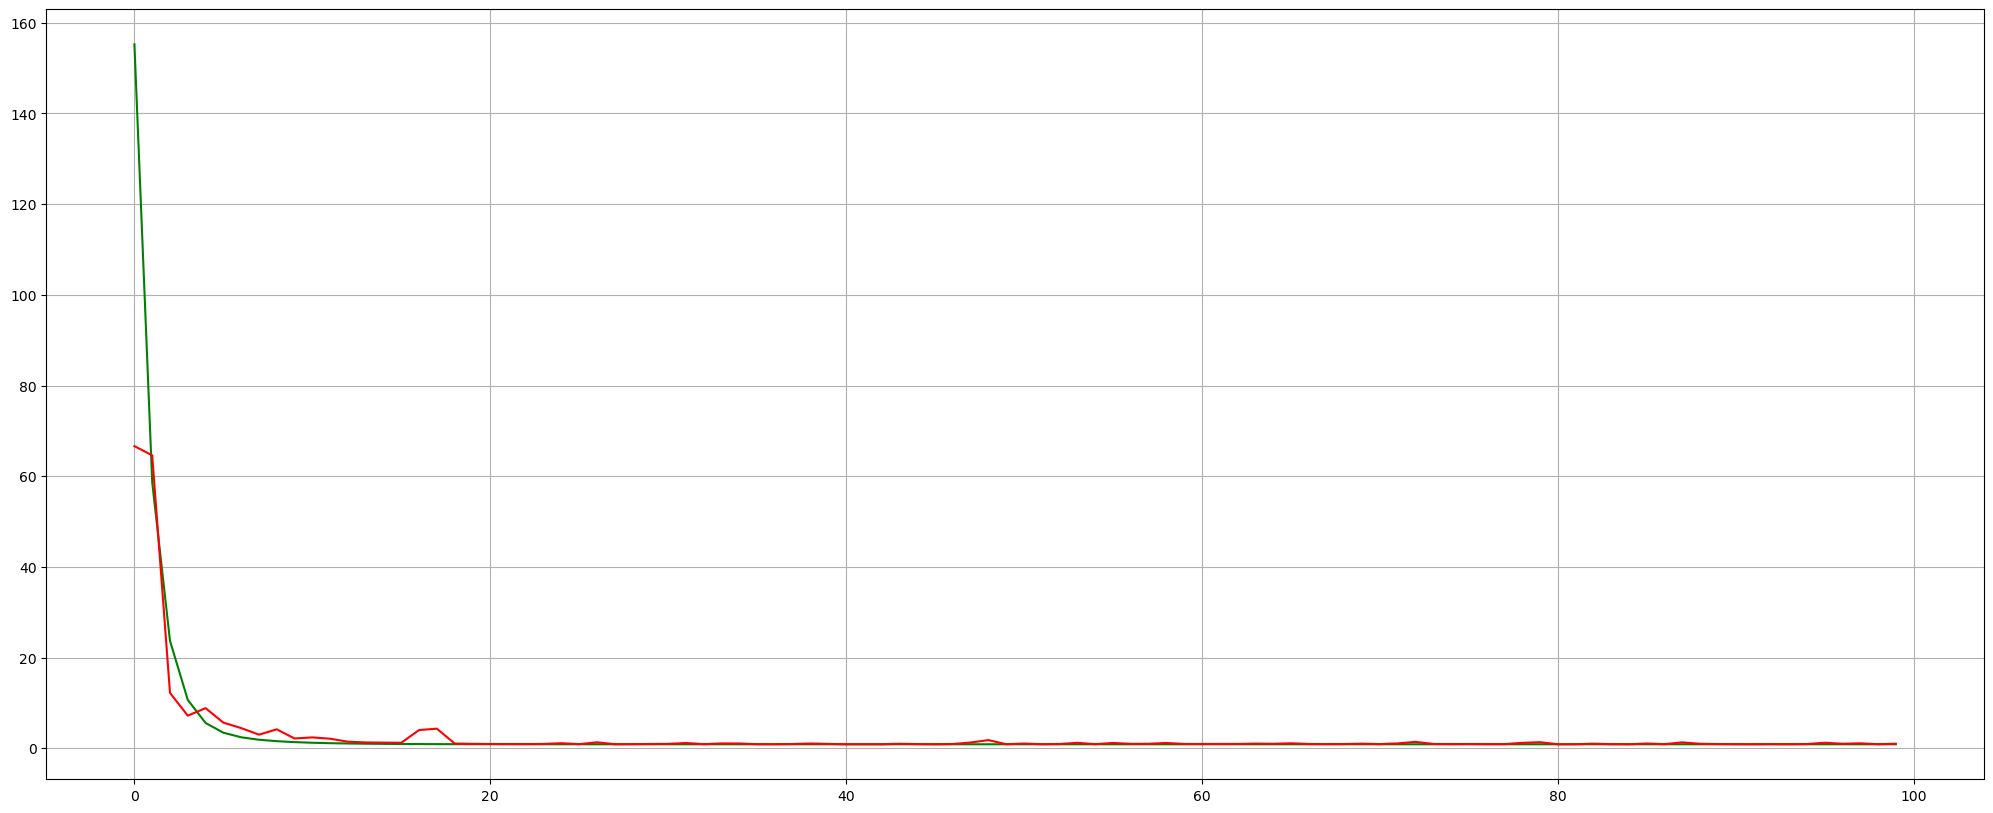

In [273]:
x1 = k_gd
x2 = k_sgd

y1 = gd
y2 = sgd

fig = plt.figure(figsize=(25,10))
ax = plt.subplot(111)
f = ax.plot(x1,y1, color='green', label='GD')
ax.plot(x2,y2, color='red', label='SGD')

ax.grid(True)
plt.show()

## Линейная Регрессия

In [393]:
class LinearRegression1:
    def __init__(self, loss: BaseLoss, lr: float=0.1):
        self.loss = loss
        self.lr = lr
        self.w = None
        self.g = None

    def fit(self, X: np.ndarray, y: np.ndarray):
        X = np.asarray(X)
        y = np.asarray(y)

        X = np.hstack([X, np.ones([X.shape[0], 1])])
        shape_X = X.shape

        self.w = np.arange(shape_X[-1])
        self.g = gradient_descent(self.w, X, y, self.loss, lr=self.lr, n_iterations=100000)
        return self.g[-1]
        
    def predict(self, X : np.ndarray):
        X = np.hstack([X, np.ones([X.shape[0], 1])])
        y = np.dot(X, self.g[-1])

        return y

In [304]:
linear_regression = LinearRegression1(MSELoss())

Загружаем датасет

In [323]:
X_raw = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data",
    header=None,
    na_values=["?"]
)

In [313]:
print(X_raw.shape)
X_raw.head()

(205, 26)


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


In [325]:
X_raw = X_raw[~X_raw[25].isna()].reset_index()
X_raw.shape
#Так просто удаляем образцы где 25-ый признак пропущен (nan)

(201, 27)

In [327]:
y = X_raw[25]
X_raw = X_raw.drop(25,axis=1)

In [335]:
X_raw.isnull().any().any()
#Если вкратце - да, есть пропуски

True

In [341]:
pusto = X_raw.isna().sum()
pusto = pusto[pusto > 0]
pusto

1     37
5      2
18     4
19     4
21     2
22     2
dtype: int64

In [343]:
X_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   201 non-null    int64  
 1   0       201 non-null    int64  
 2   1       164 non-null    float64
 3   2       201 non-null    object 
 4   3       201 non-null    object 
 5   4       201 non-null    object 
 6   5       199 non-null    object 
 7   6       201 non-null    object 
 8   7       201 non-null    object 
 9   8       201 non-null    object 
 10  9       201 non-null    float64
 11  10      201 non-null    float64
 12  11      201 non-null    float64
 13  12      201 non-null    float64
 14  13      201 non-null    int64  
 15  14      201 non-null    object 
 16  15      201 non-null    object 
 17  16      201 non-null    int64  
 18  17      201 non-null    object 
 19  18      197 non-null    float64
 20  19      197 non-null    float64
 21  20      201 non-null    float64
 22  21

In [347]:
X_raw[1] = X_raw[1].fillna(X_raw[1].mean())

In [349]:
X_raw[5].value_counts()

5
four    113
two      86
Name: count, dtype: int64

In [351]:
X_raw[5] = X_raw[5].fillna('four')

In [359]:
columns = [18,19,21,22]

for el in columns:
    print(el)
    print('Мода:',mode(X_raw[el])[0])
    X_raw[el] = X_raw[el].fillna(mode(X_raw[el])[0])

18
Мода: 3.62
19
Мода: 3.4
21
Мода: 68.0
22
Мода: 4800.0


In [361]:
X_raw.isna().any().any()

False

Теперь готовим наши данные, изблавляемся от категориальных признаков

In [365]:
columns = [3,4,5,8]

for col in columns:
    print(X_raw[col].unique())

['gas' 'diesel']
['std' 'turbo']
['two' 'four']
['front' 'rear']


In [367]:
for col in columns:
    X_raw[col] = LabelEncoder().fit_transform(X_raw[col])

In [369]:
X_raw.head()

,index,0,1,2,3,4,5,6,7,8,...,15,16,17,18,19,20,21,22,23,24
0,0,3,122.0,alfa-romero,1,0,1,convertible,rwd,0,...,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27
1,1,3,122.0,alfa-romero,1,0,1,convertible,rwd,0,...,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27
2,2,1,122.0,alfa-romero,1,0,1,hatchback,rwd,0,...,six,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26
3,3,2,164.0,audi,1,0,0,sedan,fwd,0,...,four,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30
4,4,2,164.0,audi,1,0,0,sedan,4wd,0,...,five,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22


In [371]:
X_raw = X_raw.drop('index', axis = 1)

In [373]:
cat_mask = X_raw.select_dtypes(include=['object']).columns

In [375]:
X_raw = pd.get_dummies(X_raw, columns=cat_mask, drop_first=True)

In [377]:
X_raw.columns

Index([                0,                 1,                 3,
                       4,                 5,                 8,
                       9,                10,                11,
                      12,                13,                16,
                      18,                19,                20,
                      21,                22,                23,
                      24,          '2_audi',           '2_bmw',
           '2_chevrolet',         '2_dodge',         '2_honda',
               '2_isuzu',        '2_jaguar',         '2_mazda',
       '2_mercedes-benz',       '2_mercury',    '2_mitsubishi',
              '2_nissan',        '2_peugot',      '2_plymouth',
             '2_porsche',       '2_renault',          '2_saab',
              '2_subaru',        '2_toyota',    '2_volkswagen',
               '2_volvo',       '6_hardtop',     '6_hatchback',
               '6_sedan',         '6_wagon',           '7_fwd',
                 '7_rwd',            '14

In [379]:
X_raw.columns = X_raw.columns.astype(str)

In [381]:
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size = 0.3)

In [383]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [395]:
lin_reg = LinearRegression1(MSELoss(), lr=0.01)
lin_reg.fit(X_train, y_train)

array([-1.83022305e+02, -9.37733954e+00, -1.89373848e+03,  8.56685239e+02,
       -4.51504801e+02,  1.00689171e+03,  1.89438345e+03, -1.88658997e+03,
        1.72230178e+03, -9.06686632e+02,  2.34195946e+03,  4.48745065e+03,
       -1.11624109e+03, -3.41010992e+02, -3.25440401e+03, -1.59487115e+02,
        9.78059125e+02, -6.70371170e+02,  1.22813217e+03,  1.16831393e+02,
        9.37132918e+02, -7.37848203e+02, -1.12508791e+03, -5.96998310e+02,
       -2.99198355e+02, -1.58996054e+02, -8.46881832e+02,  2.64118040e+02,
        2.80000000e+01, -1.34721793e+03, -9.05846660e+02, -8.56364681e+02,
       -1.22720128e+03,  1.03489171e+03, -2.67480703e+02,  1.26060595e+02,
       -8.08235604e+02, -1.42103608e+03, -6.28818863e+02, -3.12451395e+02,
       -3.50736958e+02, -1.61203721e+03, -1.51790574e+03, -9.40846446e+02,
       -5.95576192e+02, -1.94287316e+02, -6.62562461e+02, -3.67113816e+02,
       -1.03102498e+02, -6.29777610e+02,  4.27536254e+02, -9.35727552e+02,
       -9.84864653e+02, -

In [397]:
print("MSE train: ", mean_squared_error(y_train, lin_reg.predict(X_train)))
print("MSE test: ", mean_squared_error(y_test, lin_reg.predict(X_test)))

MSE train:  1624880.8840536606
MSE test:  4677472.286065159


MSE с L2 регуляризацией

In [400]:
class MSEL2Loss(BaseLoss):
    def __init__(self, coef: float = 1.):
        """
        :param coef: коэффициент регуляризации (лямбда в формуле)
        """
        self.coef = coef

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: число -- значения функции потерь
        """
        # ВАЖНО! последний элемент вектора w — это bias (колонка из единиц — константный признак),
        # bias регуляризовать не нужно! Уберем последний элемент из w при подсчете слагаемого lambda||w||^2
        Q = ((linalg.norm(np.dot(X,w) - y))**2)/len(y) + self.coef*linalg.norm(w[:-1]**2)
        return Q


    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        L = np.dot(X,w)-y
        Xt = np.transpose(X)
        w = np.append(w[:-1], 0)
        Grad = 2*np.dot(Xt, L)/len(y) + 2*self.coef*w
        return Grad

In [402]:
linear_regression = LinearRegression1(MSEL2Loss(0.1))

In [404]:
alphas = [10, 1, 0.1, 0.01, 0.001, 0.0001]
model = Ridge()
grid = GridSearchCV(estimator = model, param_grid = dict(alpha=alphas), scoring = 'neg_mean_squared_error')
grid.fit(X_train, y_train)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': [10, 1, 0.1, 0.01, 0.001, 0.0001]},
             scoring='neg_mean_squared_error')

In [406]:
print('best alpha: ', grid.best_estimator_.alpha)
print('MSE test ', mean_squared_error(y_test, grid.predict(X_test)))

best alpha:  10
MSE test  4588134.147178178


Реализуем класс HuberLoss

In [409]:
class HuberLoss(BaseLoss):
    def __init__(self, eps: float) -> None:
        """
        :param eps: параметр huber loss из формулы
        """
        self.eps = eps

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: число -- значения функции потерь
        """

        # Вычислите значение функции потерь при помощи X, y и w и верните его

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """



Обучим регрессию с лоссом HuberLoss